In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from utils import *
import glob
from scipy import stats

In [2]:
#reading data
d='/glade/derecho/scratch/djk2120/postp/jas/'
dvs=['SOILWATER_10CM','ET','PREC']
ds=xr.Dataset()
for v in dvs:
    files=sorted(glob.glob(d+v+'*.nc'))
    ds[v]=xr.open_mfdataset(files,combine='by_coords')[v]
#ds=ds.sel(year=slice(2020,2100))

In [7]:
client=get_cluster()

In [10]:
files=[list(lens_files('EFLX_LH_TOT','lnd','h0',yr)) for yr in [2000,2010]]

In [13]:
ds=xr.open_mfdataset(files,combine='nested',concat_dim=['time','ens'],
                     parallel=True)

In [14]:
ds=fix_time(ds)
x=amean(ds.EFLX_LH_TOT)
x0=gmean(x.sel(year=slice(2005,2014)),la).mean()

In [38]:
files=[list(lens_files('EFLX_LH_TOT','lnd','h0',yr)) for yr in [2090,2100]]
ds=xr.open_mfdataset(files,combine='nested',concat_dim=['time','ens'],
                     parallel=True)

In [39]:
ds=fix_time(ds)
x=amean(ds.EFLX_LH_TOT)
x1=gmean(x.sel(year=slice(2090,2099)),la).mean()

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 9.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [41]:
x1/x0

<xarray.DataArray ()>
array(1.02925287)

In [21]:
tmp=xr.open_dataset(files[0][0])

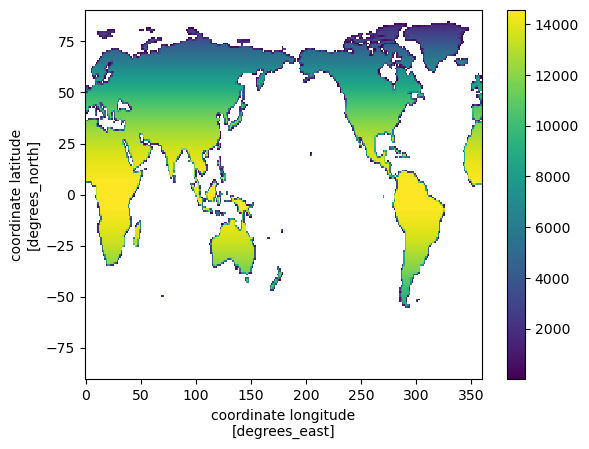

In [27]:
la.plot()

In [26]:
la=(tmp.area*tmp.landfrac).where(tmp.lat>-60)

In [19]:
x.sel(year=slice(2005,2014))

<xarray.DataArray (year: 10, ens: 100, lat: 192, lon: 288)>
array([[[[-0.33538072, -0.33539595, -0.33538157, ..., -0.33538036,
          -0.33539565, -0.33538069],
         [-0.25377685, -0.25349608, -0.24386911, ..., -0.24914413,
          -0.25084838, -0.25290624],
         [-0.15967687, -0.15795672, -0.16299594, ..., -0.17002819,
          -0.16989156, -0.1679    ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[-0.34537332, -0.34537384, -0.34537144, ..., -0.34537736,
          -0.3453736 , -0.34537355],
         [-0.25377409, -0.25264842, -0.24235281, ..., -0.24826146,
          -0.25040614, -0.25191749],
         [-0.22970282, -0.23124611, -0.23363012, ..., -0.23451562,
          -0.23652371, -0.23588274],
...
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[-0.31562679, -0.31563743, -0.31563842, ..., -0.31564087,
          -0.31564034, -0.31564038],
         [-0.24686413, -0.24642878, -0.23555301, ..., -0.24384722,
          -0.24415384, -0.24716924],
         [-0.22563365, -0.22411441, -0.22675203, ..., -0.23614053,
          -0.235606  , -0.22952901],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]]]])
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * year     (year) int64 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
Dimensions without coordinates: ens

In [3]:
ds.ET.sel(year=slice(2005,2014))

<xarray.DataArray 'ET' (year: 251, ens: 100)>
dask.array<concatenate, shape=(251, 100), dtype=float64, chunksize=(10, 100), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: ens

In [4]:
#reorganizing data
nx=20
ee=int(np.round(len(ds.ens)/nx))
dsq=xr.Dataset()
for v in ['SOILWATER_10CM','PREC','ET']:
    das=[x.sortby(s) for x,s in zip(ds[v],ds['SOILWATER_10CM'])]
    dsq[v]=xr.concat([xr.concat([da.sel(ens=slice(ee*i,ee+ee*i)) 
                            for i in range(nx)],
                           dim='quantile') 
                 for da in das],dim='year')

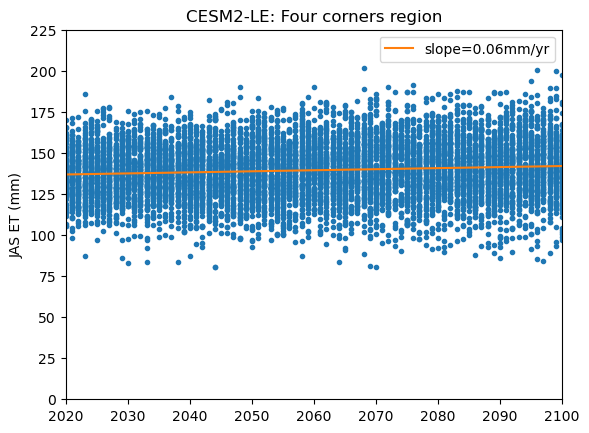

In [7]:
cf=24*60*60*92
et=cf*dsq.ET.stack({'eqy':['ens','quantile','year']}).swap_dims({'eqy':'year'})
et['year']=et.year.values
p=et.polyfit(dim='year',deg=1)
m=np.round(p.polyfit_coefficients.sel(degree=1).values,2)
plt.plot(et.year,et,'.')
plt.plot(ds.year,xr.polyval(ds.year,p.polyfit_coefficients),
         label='slope='+str(m)+'mm/yr')
plt.xlim([2020,2100])
plt.ylim([0,225])
plt.legend()
plt.ylabel('JAS ET (mm)')
plt.title('CESM2-LE: Four corners region');

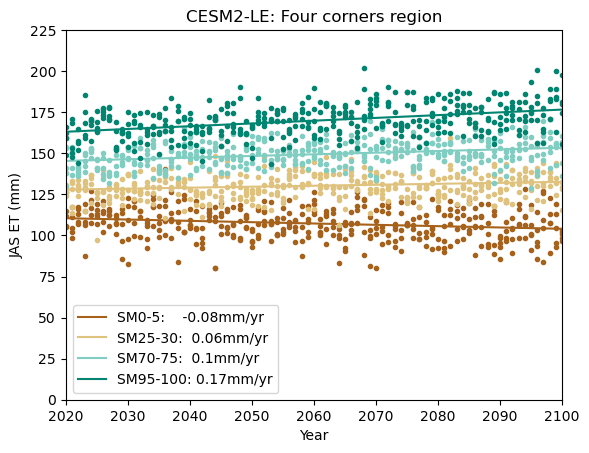

In [24]:
v = 'ET'

#compute ET and perform regression
x = cf * dsq[v].stack({'ensyear': ['ens', 'year']}).swap_dims({'ensyear': 'year'})
x['year'] = x.year.values
p = x.polyfit(dim='year', deg=1)
fits = xr.polyval(ds.year, p.polyfit_coefficients)

#plotting
colors = ['#a6611a', '#dfc27d', '#80cdc1', '#018571']
for c, q in zip(colors, [0, 5, 14, 19]):
    m = np.round(p.polyfit_coefficients.sel(quantile=q, degree=1).values, 2)
    label = ('SM' + str(int(100*q/nx)) + '-' +
             str(int(100/nx + 100*q/nx)) + ':').ljust(10) + str(m) + 'mm/yr'
    plt.plot(x.year, x.sel(quantile=q), '.', color=c)
    plt.plot(ds.year, fits.sel(quantile=q), color=c, label=label)
plt.xlim([2020, 2100])
plt.ylim([0, 225])
plt.legend(loc=3)
plt.xlabel('Year')
plt.title('CESM2-LE: Four corners region')
plt.ylabel('JAS '+v+' (mm)');

### useful xarray functions
 - lm = da.polyfit(dim='year', deg=1)
    - regress a DataArray against one of its coordinates
 - fit = xr.polyval(da.year, lm.polyfit_coefficients)
    - evaluate the regression line for plotting
    - plt.plot(da.year,fit)
 - da.stack({'ensyear': ['ens', 'year']})
    - stack ensemble and year into one dimension

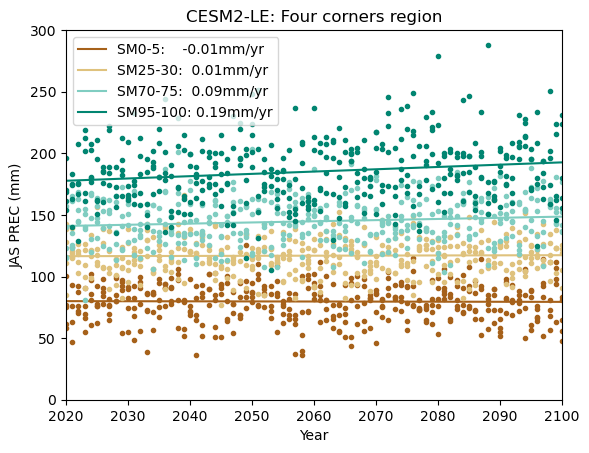

In [27]:
v = 'PREC'

#compute ET and perform regression
x = cf * dsq[v].stack({'ensyear': ['ens', 'year']}).swap_dims({'ensyear': 'year'})
x['year'] = x.year.values
p = x.polyfit(dim='year', deg=1)
fits = xr.polyval(ds.year, p.polyfit_coefficients)

#plotting
colors = ['#a6611a', '#dfc27d', '#80cdc1', '#018571']
for c, q in zip(colors, [0, 5, 14, 19]):
    m = np.round(p.polyfit_coefficients.sel(quantile=q, degree=1).values, 2)
    label = ('SM' + str(int(100*q/nx)) + '-' +
             str(int(100/nx + 100*q/nx)) + ':').ljust(10) + str(m) + 'mm/yr'
    plt.plot(x.year, x.sel(quantile=q), '.', color=c)
    plt.plot(ds.year, fits.sel(quantile=q), color=c, label=label)
plt.xlim([2020, 2100])
plt.ylim([0, 300])
plt.legend(loc=2)
plt.xlabel('Year')
plt.title('CESM2-LE: Four corners region')
plt.ylabel('JAS '+v+' (mm)');

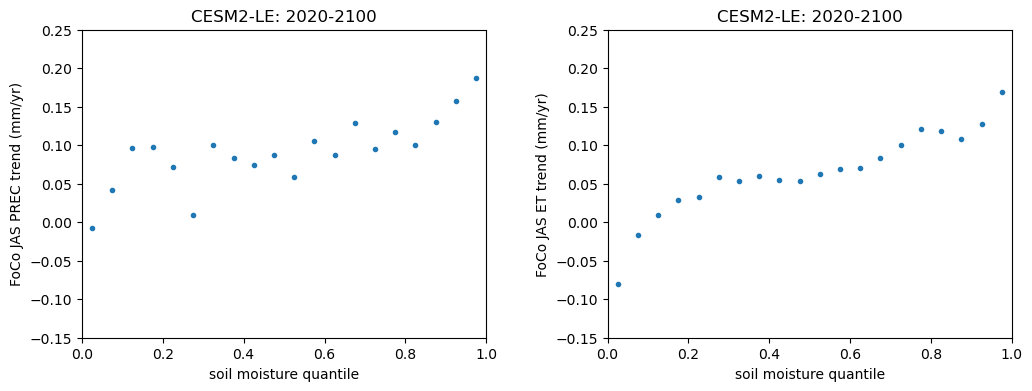

In [31]:
plt.figure(figsize=[12,4])
for i,v in enumerate(['PREC','ET']):
    plt.subplot(121+i)
    x=cf*dsq[v].stack({'ey':['ens','year']}).swap_dims({'ey':'year'})
    x['year']=x.year.values
    p=x.polyfit(dim='year',deg=1)
    plt.plot(np.arange(nx)/nx+1/nx/2,p.polyfit_coefficients.sel(degree=1),'.')
    plt.xlim([0,1])
    plt.xlabel('soil moisture quantile')
    plt.ylabel('FoCo JAS '+v+' trend (mm/yr)')
    plt.ylim([-0.15,0.25])
    plt.title('CESM2-LE: 2020-2100')
plt.subplots_adjust(wspace=0.3)

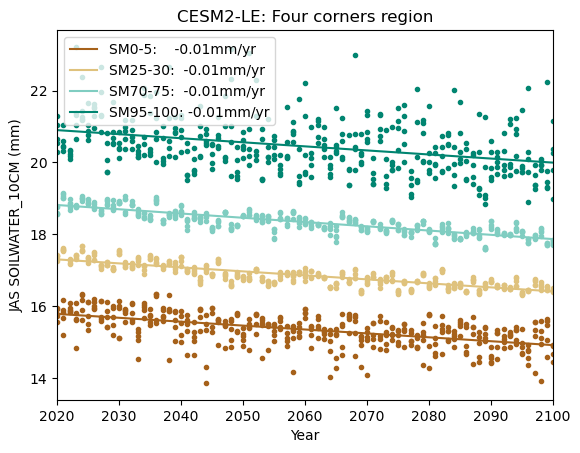

In [33]:
v = 'SOILWATER_10CM'

#compute ET and perform regression
x = dsq[v].stack({'ensyear': ['ens', 'year']}).swap_dims({'ensyear': 'year'})
x['year'] = x.year.values
p = x.polyfit(dim='year', deg=1)
fits = xr.polyval(ds.year, p.polyfit_coefficients)

#plotting
colors = ['#a6611a', '#dfc27d', '#80cdc1', '#018571']
for c, q in zip(colors, [0, 5, 14, 19]):
    m = np.round(p.polyfit_coefficients.sel(quantile=q, degree=1).values, 2)
    label = ('SM' + str(int(100*q/nx)) + '-' +
             str(int(100/nx + 100*q/nx)) + ':').ljust(10) + str(m) + 'mm/yr'
    plt.plot(x.year, x.sel(quantile=q), '.', color=c)
    plt.plot(ds.year, fits.sel(quantile=q), color=c, label=label)
plt.xlim([2020, 2100])
#plt.ylim([0, 300])
plt.legend(loc=2)
plt.xlabel('Year')
plt.title('CESM2-LE: Four corners region')
plt.ylabel('JAS '+v+' (mm)');